# Data Augmentation

## Imports

In [ ]:
from google.colab import drive
import zipfile
import os

import torch
import random
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision.models import googlenet

In [ ]:
# Use drive.mount with force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/ML Project 2 :)/data (2).zip'

# Extract to a working directory
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Utility functions

Custom augmentation class

*   Allows for the application of random transformations to selected percentages of the dataset
*   Allows for the application of random transformations to just cracked data, just uncracked data, or both
*   Custom class for data augmentation required to minimize RAM usage
*   Includes random application of 90, 180, 270 rotations and horizontal and vertical flips
*   Also lighting functionality (not used in the final report)



In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, clean_percentage=0.0, cracked_percentage=0.0,
                 clean_lighting_percentage=0.0, cracked_lighting_percentage=0.0,
                 seed=None, device='cpu'):
        """
        Custom dataset to apply random transformations selectively and augment dataset size.

        Args:
            dataset: Original dataset (e.g., datasets.ImageFolder).
            clean_percentage (float): Percentage of 'clean' (label 0) to apply transformations.
            cracked_percentage (float): Percentage of 'cracked' (label 1) to apply transformations.
            clean_lighting_percentage (float): Percentage of 'clean' (label 0) to apply random lighting shifts.
            cracked_lighting_percentage (float): Percentage of 'cracked' (label 1) to apply random lighting shifts.
            seed (int, optional): Random seed for reproducibility.
            device (str): Device to use ('cpu' or 'cuda').
        """
        self.dataset = dataset
        self.clean_percentage = clean_percentage
        self.cracked_percentage = cracked_percentage
        self.clean_lighting_percentage = clean_lighting_percentage
        self.cracked_lighting_percentage = cracked_lighting_percentage
        self.device = device

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Separate indices by labels
        self.clean_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
        self.cracked_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

        # Precompute augmented data indices
        self.rotation_indices = set(
            random.sample(self.clean_indices, int(len(self.clean_indices) * clean_percentage)) +
            random.sample(self.cracked_indices, int(len(self.cracked_indices) * cracked_percentage))
        )
        self.lighting_indices = set(
            random.sample(self.clean_indices, int(len(self.clean_indices) * clean_lighting_percentage)) +
            random.sample(self.cracked_indices, int(len(self.cracked_indices) * cracked_lighting_percentage))
        )

        self.rotation_transforms = self.get_rotation_transforms()

    def get_rotation_transforms(self):
        """
        Predefine transformations for random rotations and flips.
        """
        return [
            lambda x: x.transpose(-1, -2),   # 90 degrees rotation
            lambda x: torch.flip(x, dims=(-1, -2)),  # 180 degrees rotation
            lambda x: torch.rot90(x, k=3, dims=(-1, -2)),  # 270 degrees rotation
            lambda x: torch.flip(x, dims=(-1,)),  # Horizontal (N-S) flip
            lambda x: torch.flip(x, dims=(-2,))   # Vertical (E-W) flip
        ]

    def __len__(self):
        return len(self.dataset) + len(self.rotation_indices) + len(self.lighting_indices)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            # For original dataset items, just return the image and label
            img, label = self.dataset[idx]
            return img.to(self.device), label

        # Handle augmented data (rotations and flips)
        idx -= len(self.dataset)
        if idx < len(self.rotation_indices):
            aug_idx = list(self.rotation_indices)[idx]
            img, label = self.dataset[aug_idx]
            return self.apply_random_transformation(img.to(self.device)), label

        # Handle lighting shift augmentation
        idx -= len(self.rotation_indices)
        aug_idx = list(self.lighting_indices)[idx]
        img, label = self.dataset[aug_idx]
        return self.apply_lighting_shift(img.to(self.device)), label

    def apply_random_transformation(self, img_tensor):
        """
        Apply a random transformation (rotation or flip).
        """
        transform = random.choice(self.rotation_transforms)
        return transform(img_tensor)

    def apply_lighting_shift(self, img_tensor):
        """
        Apply a random lighting shift to the tensor image.
        """
        brightness_factor = torch.FloatTensor(1).uniform_(0.8, 1.2).item()
        return img_tensor * brightness_factor

Testing the transforms

In [ ]:
transform_visu = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
])

visu_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform_visu)

In [ ]:
def apply_lighting_shift(img_tensor):
    """
    Apply a random lighting shift to the tensor image.
    """
    brightness_factor = torch.FloatTensor(1).uniform_(0.8, 1.2).item()  # Random brightness between 0.8 and 1.2
    return torch.clamp(img_tensor * brightness_factor, 0.0, 1.0)  # Clamp to keep values within [0, 1]

def visualize_augmentations(dataset, idx):
    """
    Visualize the original image with all the augmentations applied, including rotations, flips, and lighting changes.

    Args:
        dataset: The dataset instance (train_dataset).
        idx (int): Index of the image to visualize.
    """
    # Get the image and label from the dataset
    img, label = dataset[idx]

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Original Image
    axes[0].imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Define the rotation and flip transformations
    rotation_transforms = [
        lambda x: x.transpose(-1, -2),  # 90 degrees rotation
        lambda x: torch.flip(x, dims=(-1, -2)),  # 180 degrees rotation
        lambda x: torch.rot90(x, k=3, dims=(-1, -2)),  # 270 degrees rotation
        lambda x: torch.flip(x, dims=(-1,)),  # Horizontal flip
        lambda x: torch.flip(x, dims=(-2,))   # Vertical flip
    ]

    # Apply and visualize each rotation/flip transformation
    for i, transform in enumerate(rotation_transforms):
        augmented_img = transform(img)
        axes[i + 1].imshow(augmented_img.permute(1, 2, 0))
        axes[i + 1].set_title(f"Rotation/Flip {i+1}")
        axes[i + 1].axis('off')

    # Apply and visualize the lighting shift transformation
    augmented_img_lighting = apply_lighting_shift(img)
    axes[6].imshow(augmented_img_lighting.permute(1, 2, 0))
    axes[6].set_title("Lighting Shift")
    axes[6].axis('off')

    plt.show()

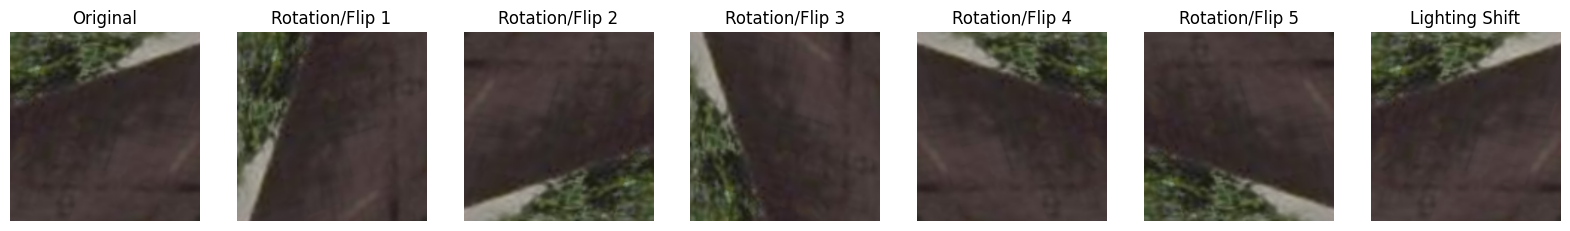

In [ ]:
visualize_augmentations(visu_dataset, 0)

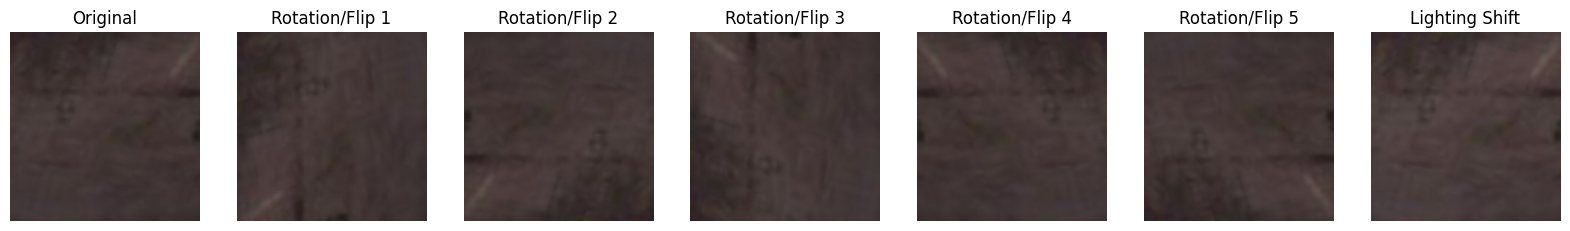

In [ ]:
visualize_augmentations(visu_dataset, 5)

Training

In [ ]:
def train_and_plot(train_loader, val_loader, model_fn, criterion, optimizer_fn, device, num_epochs, n_trials, patience, save_dir):
    """
    Trains a model n times, saves the model after each trial, and plots the training and validation loss per epoch.
    Implements early stopping.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model_fn (function): A callable that returns a new model instance initialized with pre-trained weights.
        criterion (torch.nn.Module): Loss function.
        optimizer_fn (function): Function to create a new optimizer instance for each trial.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs per training.
        n_trials (int): Number of training repetitions.
        save_dir (str): Directory where the model for each trial will be saved.
        patience (int): Number of epochs to wait for validation loss improvement before stopping early.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    sample_model = model_fn()
    model_name = type(sample_model).__name__

    plt.figure(figsize=(10, 6))

    # To store all losses for averaging
    all_train_losses = []
    all_val_losses = []

    for trial in range(n_trials):
        # Reinitialize the model with ImageNet weights
        model = model_fn().to(device)

        # Create a new optimizer instance for this trial
        optimizer = optimizer_fn(model.parameters())

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')  # Initialize to a large value
        patience_counter = 0  # Counter to track early stopping patience

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            val_loss = val_running_loss / len(val_loader)
            val_losses.append(val_loss)

            # Print loss for the current epoch
            print(f"Trial {trial + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset patience counter
                # Optionally save the best model for this trial
                trial_best_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}_best.pth")
                torch.save(model.state_dict(), trial_best_model_path)
                print(f"New best model for Trial {trial + 1} saved to {trial_best_model_path}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered for Trial {trial + 1} at Epoch {epoch + 1}")
                    break


        # Save the final model for the trial
        trial_model_path = os.path.join(save_dir, f"{model_name}_trial_{trial + 1}.pth")
        torch.save(model.state_dict(), trial_model_path)
        print(f"Final model for Trial {trial + 1} saved to {trial_model_path}")

        # Store losses for averaging
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Plot training and validation losses for this trial
        plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', alpha=0.3, label='Training Loss' if trial == 0 else "")
        plt.plot(range(1, len(val_losses) + 1), val_losses, color='orange', alpha=0.3, label='Validation Loss' if trial == 0 else "")

    # Calculate average losses per epoch
    avg_train_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_train_losses)]
    avg_val_losses = [sum(epoch_losses) / n_trials for epoch_losses in zip(*all_val_losses)]

    # Plot average lines
    plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, color='blue', linewidth=2, label='Avg Training Loss')
    plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, color='orange', linewidth=2, label='Avg Validation Loss')

    # Finalize plot
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis shows integer epochs
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Across Trials")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

ROC curves

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_average_roc(models, val_loader, device, labels):
    """
    Plots the ROC curve for multiple models and their average.

    Args:
        models (list of torch.nn.Module): List of trained models.
        val_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to use (CPU or GPU).
        labels (list of str): Names of the models for legend labeling.
    """
    all_fpr = np.linspace(0, 1, 100)  # Common FPR axis for interpolation
    tpr_list = []  # Store TPR values for each model's interpolated curve
    auc_list = []  # Store AUC values for each model

    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        model.eval()
        true_labels = []
        pred_probs = []

        # Disable gradient computation during evaluation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                probabilities = outputs[:, 1]  # Use logits for positive class

                # Append true labels and predicted probabilities
                true_labels.extend(labels.cpu().numpy())
                pred_probs.extend(probabilities.cpu().numpy())

        # Calculate ROC curve metrics
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)

        # Interpolate TPR to common FPR axis
        interpolated_tpr = np.interp(all_fpr, fpr, tpr)
        tpr_list.append(interpolated_tpr)

        # Plot individual model's ROC curve in light grey
        plt.plot(fpr, tpr, color='lightgrey', lw=1, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

    # Compute the average TPR
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve in blue
    plt.plot(all_fpr, mean_tpr, color='blue', lw=2, label=f"Average (AUC = {mean_auc:.2f})")

    # Add baseline
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier (AUC = 0.5)")

    # Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve Across Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

Data augmentation : general

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for ResNet
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats to use pretrained weights
])

# Load the datasets again using the final transformation
train_dataset = datasets.ImageFolder(os.path.join(extract_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(extract_path, 'validation'), transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
def create_googlenet():
    model = googlenet(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model

# Define optimizer function
def optimizer_fn(params):
    return torch.optim.Adam(params, lr=1e-3)

criterion = nn.CrossEntropyLoss()

## Determine subset of data to apply transforms to

Questions Investigated:

*   What percent of the data should transforms be applied to for improving model performance?
*   Should transforms be applied to only cracked data, or both cracked and uncracked data?



### Training

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.0
cracked_rotation_percentage=0.1
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
52793


Trial 1, Epoch 1, Train Loss: 0.2147, Val Loss: 0.2412
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1657, Val Loss: 0.2441
Trial 1, Epoch 3, Train Loss: 0.1420, Val Loss: 0.2440
Trial 1, Epoch 4, Train Loss: 0.1207, Val Loss: 0.2521
Trial 1, Epoch 5, Train Loss: 0.1012, Val Loss: 0.3164
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2144, Val Loss: 0.2423
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1693, Val Loss: 0.2685
Trial 2, Epoch 3, Train Loss: 0.1455, Val Loss: 0.1910
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/

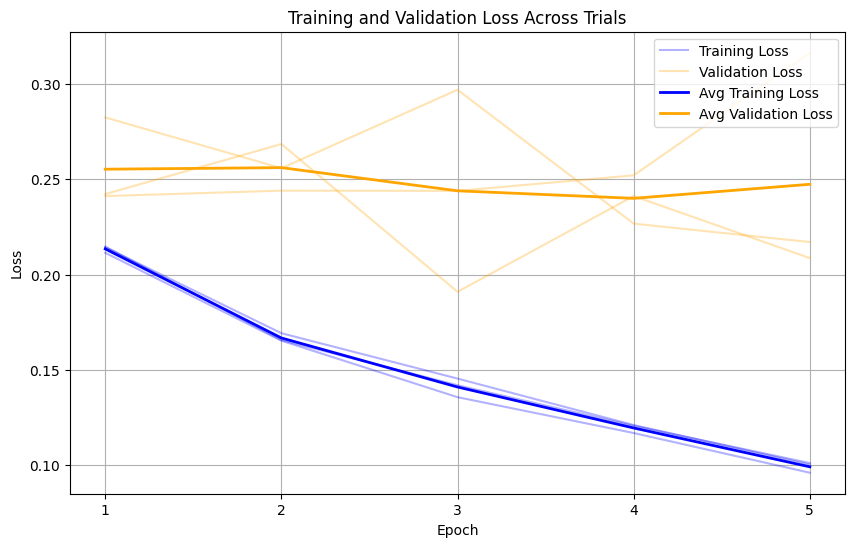

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 94.9MB/s]


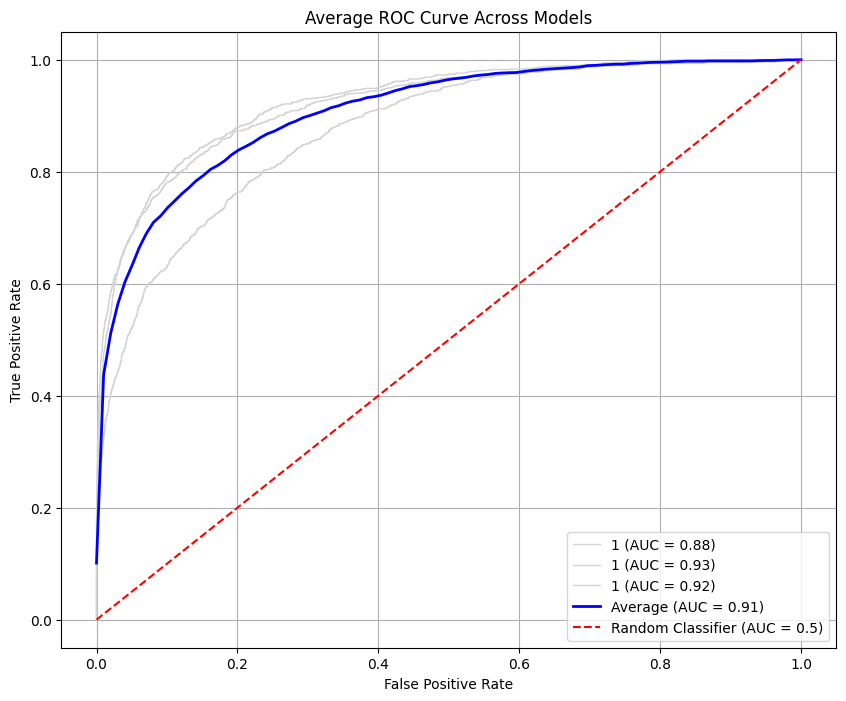

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/10%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.0
cracked_rotation_percentage=0.2
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
53394


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 127MB/s]


Trial 1, Epoch 1, Train Loss: 0.2191, Val Loss: 0.2362
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1745, Val Loss: 0.2158
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1506, Val Loss: 0.3298
Trial 1, Epoch 4, Train Loss: 0.1324, Val Loss: 0.2115
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 5, Train Loss: 0.1075, Val Loss: 0.2431
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2224, Val Loss: 0.2841
New best model for Trial 2 saved to /content/drive/MyDrive/ML Proj

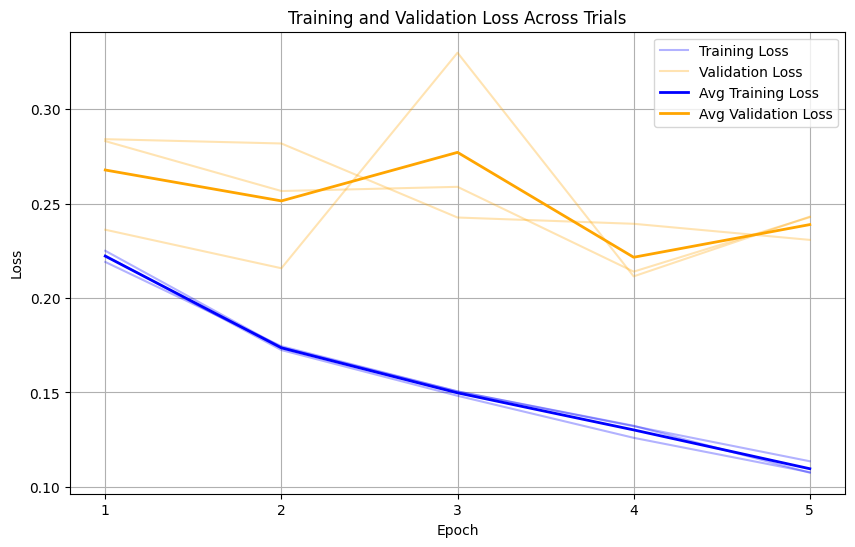

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%')

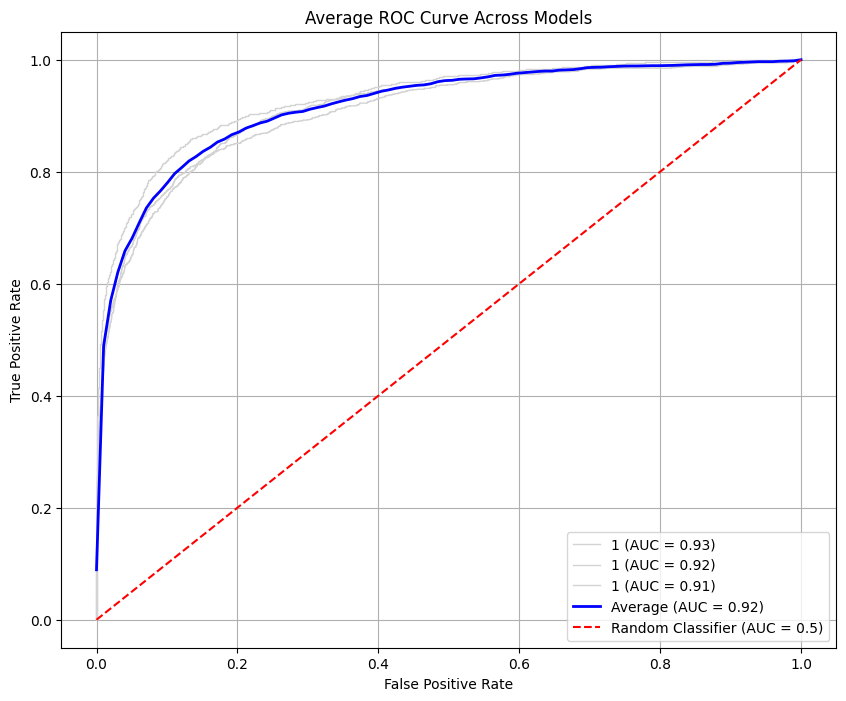

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/20%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.0
cracked_rotation_percentage=0.5
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
55196


Trial 1, Epoch 1, Train Loss: 0.2437, Val Loss: 0.2030
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1896, Val Loss: 0.2791
Trial 1, Epoch 3, Train Loss: 0.1587, Val Loss: 0.2615
Trial 1, Epoch 4, Train Loss: 0.1383, Val Loss: 0.2420
Trial 1, Epoch 5, Train Loss: 0.1197, Val Loss: 0.2570
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2388, Val Loss: 0.3193
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1852, Val Loss: 0.2971
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_2_best.pth
Trial 2, Ep

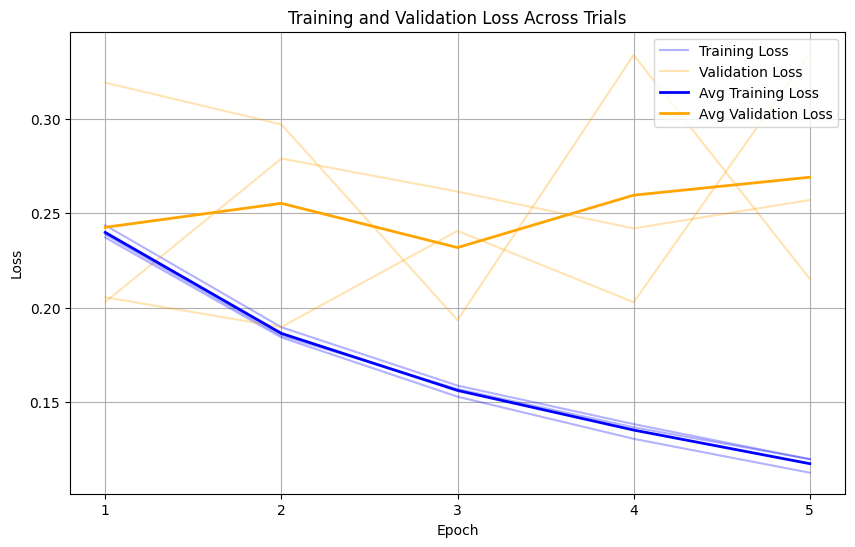

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%')

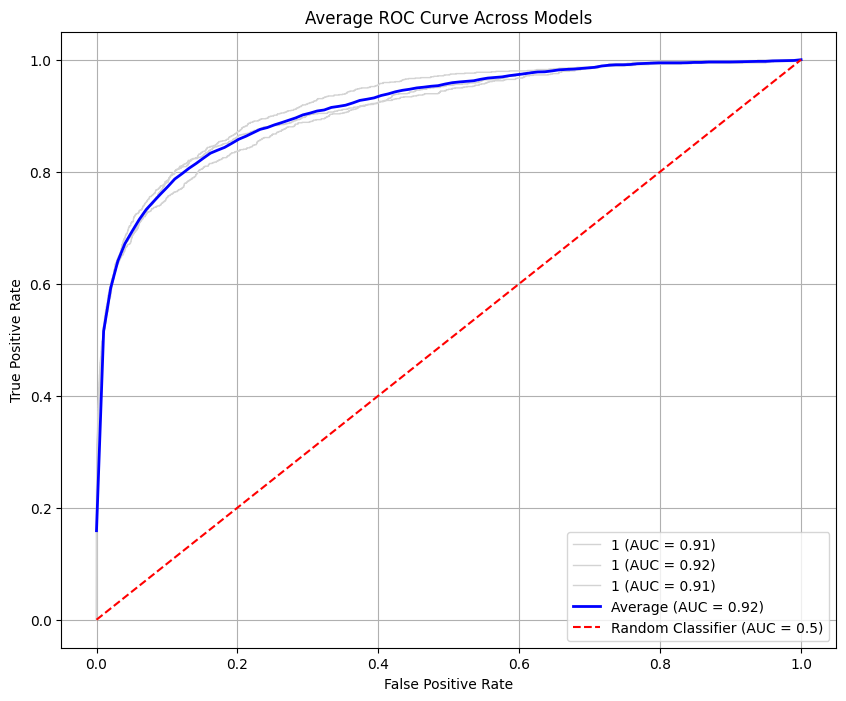

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/cracked_only/50%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.1
cracked_rotation_percentage=0.1
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
57411


Trial 1, Epoch 1, Train Loss: 0.1986, Val Loss: 0.2506
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1546, Val Loss: 0.2512
Trial 1, Epoch 3, Train Loss: 0.1287, Val Loss: 0.2237
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 4, Train Loss: 0.1115, Val Loss: 0.2369
Trial 1, Epoch 5, Train Loss: 0.0900, Val Loss: 0.4383
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2011, Val Loss: 0.2921
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1620, Val Loss

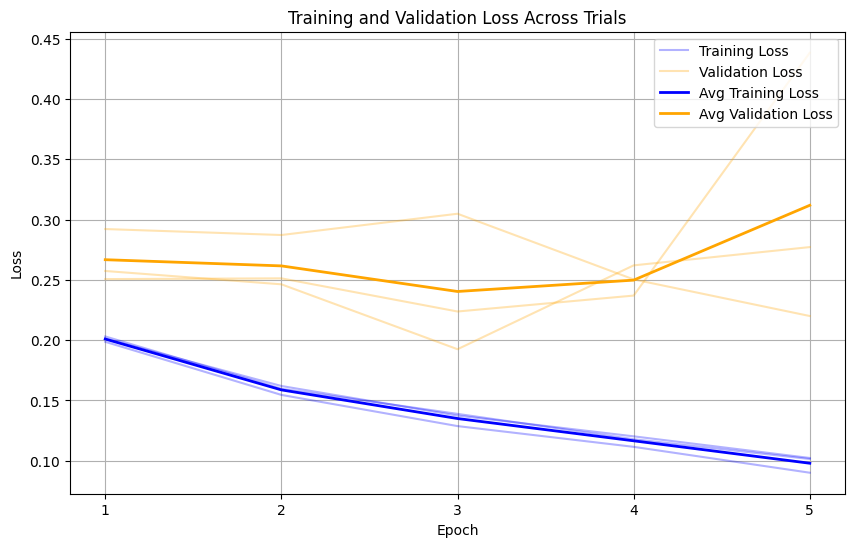

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%')

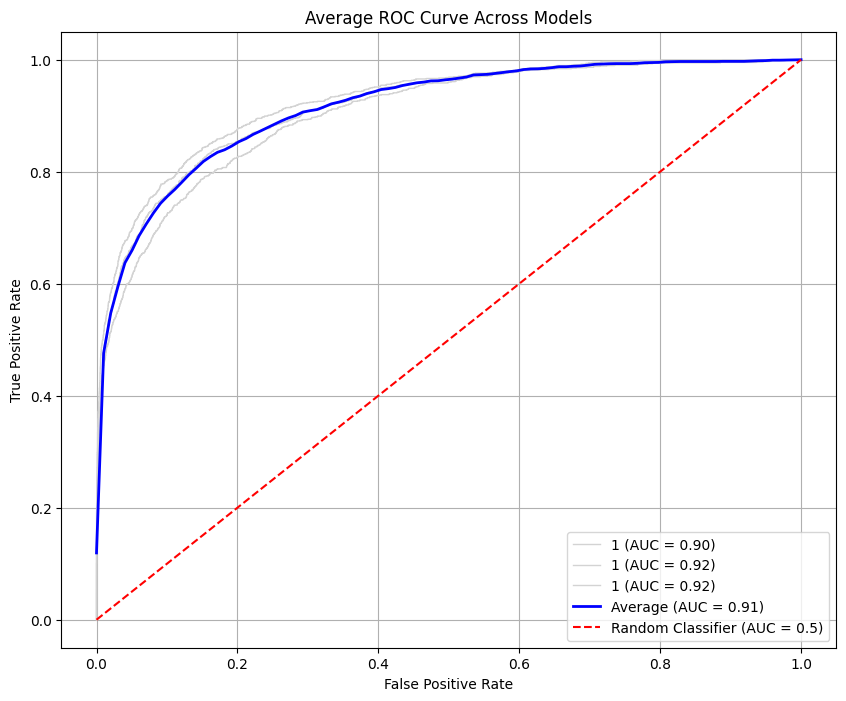

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/10%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.2
cracked_rotation_percentage=0.2
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
62631


Trial 1, Epoch 1, Train Loss: 0.2005, Val Loss: 0.3137
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1602, Val Loss: 0.2106
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1384, Val Loss: 0.3432
Trial 1, Epoch 4, Train Loss: 0.1190, Val Loss: 0.1991
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 5, Train Loss: 0.1050, Val Loss: 0.2471
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2042, Val Loss: 0.4178
New best model for Trial 2 saved to /content/d

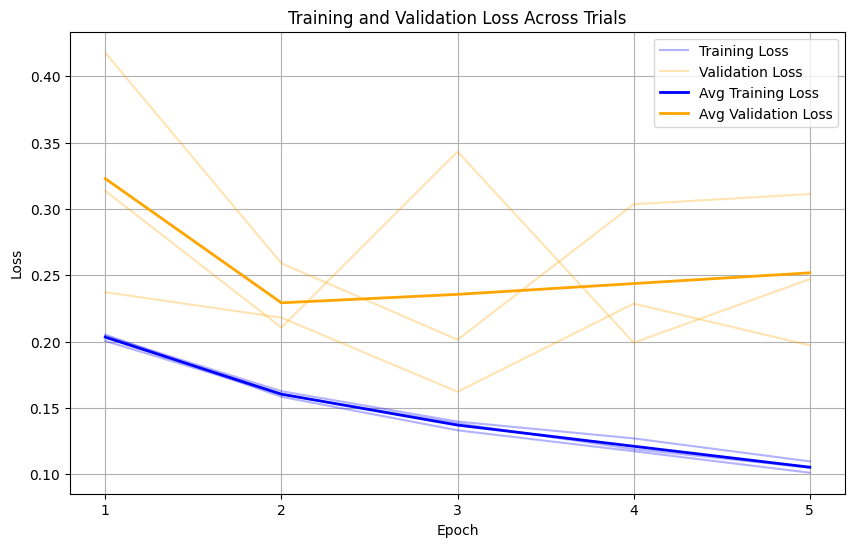

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%')

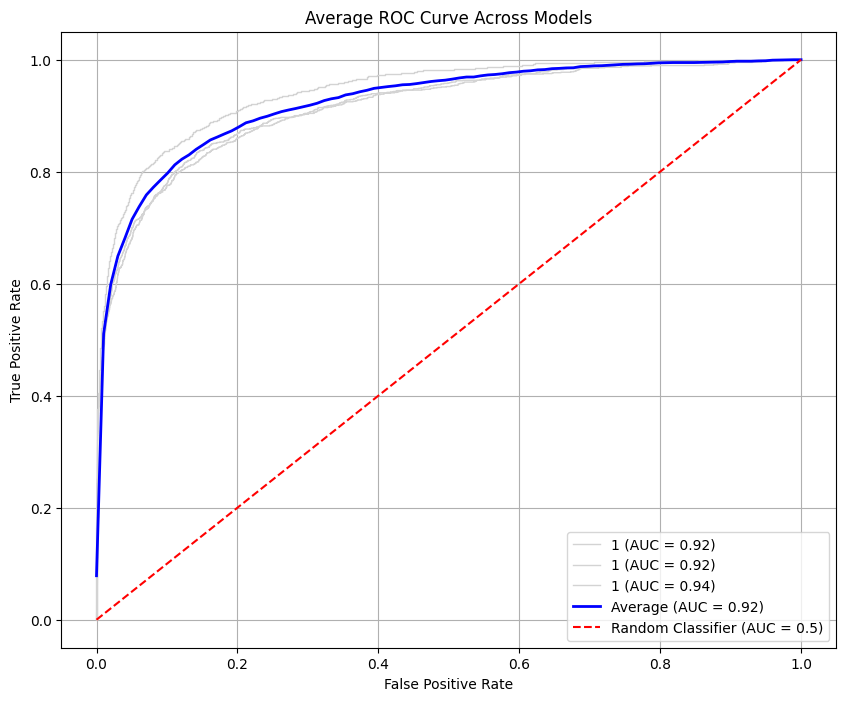

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/20%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=0.5
cracked_rotation_percentage=0.5
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
78289


Trial 1, Epoch 1, Train Loss: 0.1990, Val Loss: 0.2537
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1595, Val Loss: 0.1902
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1368, Val Loss: 0.2153
Trial 1, Epoch 4, Train Loss: 0.1226, Val Loss: 0.2059
Trial 1, Epoch 5, Train Loss: 0.1082, Val Loss: 0.2744
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.2046, Val Loss: 0.2223
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1600, Val Loss

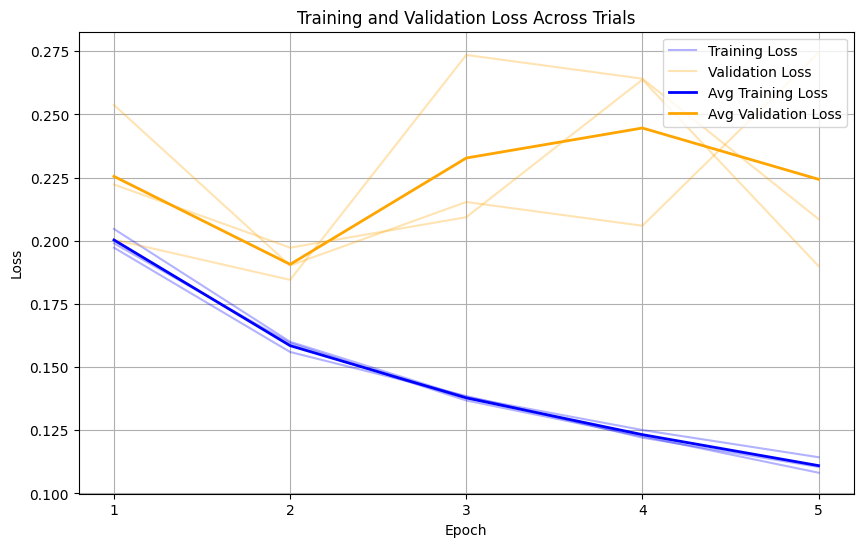

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=5, n_trials=3, patience=5, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%')

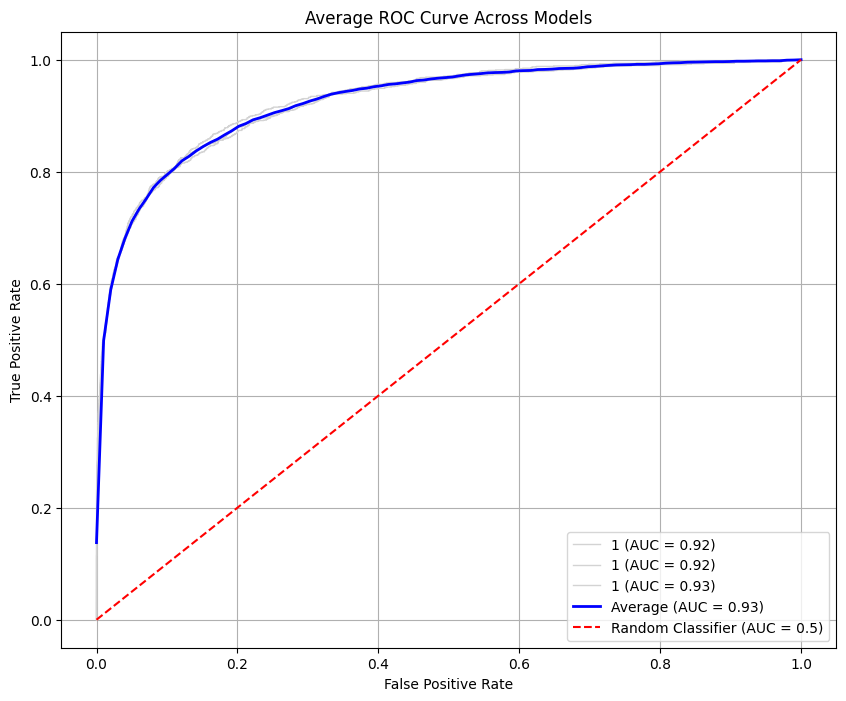

In [ ]:
googlenet1 = models.googlenet(weights="IMAGENET1K_V1")
googlenet1.fc = nn.Linear(googlenet1.fc.in_features, 2)
googlenet1.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_1_best.pth', weights_only=True))

googlenet2 = models.googlenet(weights="IMAGENET1K_V1")
googlenet2.fc = nn.Linear(googlenet2.fc.in_features, 2)
googlenet2.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_2_best.pth', weights_only=True))

googlenet3 = models.googlenet(weights="IMAGENET1K_V1")
googlenet3.fc = nn.Linear(googlenet3.fc.in_features, 2)
googlenet3.load_state_dict(torch.load('/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/50%/GoogLeNet_trial_3_best.pth', weights_only=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_models = [googlenet1, googlenet2, googlenet3]
for model in my_models:
    model = model.to(device)
labels = ["googlenet1", "googlenet2", "googlenet3"]

plot_average_roc(my_models, val_loader, device, labels)

### Conclusion

Each case has three "best models" from across the 5 epochs. We use the average validation loss from the three to fill the following table :

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind_from_stats

# Example DataFrame
data = {
    "Trial 1": [0.2245, 0.2412, 0.2115, 0.2030, 0.2237, 0.1991, 0.1902],  # Baseline and labels 1 to 6
    "Trial 2": [0.1945, 0.2412, 0.2308, 0.1934, 0.2200, 0.2014, 0.1900],
    "Trial 3": [0.2038, 0.2171, 0.2140, 0.1898, 0.1924, 0.1622, 0.1845],
}
df = pd.DataFrame(data, index=["Baseline", "0-10", "0-20", "0-50", "10-10", "20-20", "50-50"])

# Calculate mean and std for each row
df["Mean"] = df.mean(axis=1)
df["Std"] = df.std(axis=1)

# Compute t-test p-values between each label and the baseline
baseline_mean = df.loc["Baseline", "Mean"]
baseline_std = df.loc["Baseline", "Std"]
baseline_n = df.shape[1] - 2  # Number of trials (subtract "Mean" and "Std" columns)

def compute_p_value(row):
    label_mean = row["Mean"]
    label_std = row["Std"]
    label_n = baseline_n  # Assuming equal number of trials
    t_stat, p_value = ttest_ind_from_stats(
        mean1=label_mean, std1=label_std, nobs1=label_n,
        mean2=baseline_mean, std2=baseline_std, nobs2=baseline_n,
        equal_var=False  # Welch's t-test for unequal variance
    )
    return p_value

# Add p-values column
df["p_value"] = df.apply(compute_p_value, axis=1)

# Drop "p_value" for baseline row (optional)
df.loc["Baseline", "p_value"] = None

# Highlight p-values < 0.05 in bold
def format_p_value(p):
    if pd.notna(p) and p < 0.05:
        return f"**{p:.4f}**"
    elif pd.notna(p):
        return f"{p:.4f}"
    else:
        return "NaN"

df["p_value"] = df["p_value"].apply(format_p_value)

print(df)

          Trial 1  Trial 2  Trial 3      Mean       Std p_value
Baseline   0.2245   0.1945   0.2038  0.207600  0.012539     NaN
0-10       0.2412   0.2412   0.2171  0.233167  0.011361  0.0596
0-20       0.2115   0.2308   0.2140  0.218767  0.008570  0.2802
0-50       0.2030   0.1934   0.1898  0.195400  0.005571  0.2288
10-10      0.2237   0.2200   0.1924  0.212033  0.013965  0.7036
20-20      0.1991   0.2014   0.1622  0.187567  0.017962  0.1967
50-50      0.1902   0.1900   0.1845  0.188233  0.002641  0.1102


### Trying further augmentation

We can see the best result come from the highest percentage of augmentation. We try augmenting more. We did not have time do not try lighting modifications, but it would be interesting to investigate that in the future.

As this option has a higher number of iterations per epoch, we run for less epochs (half, rounded up) and because of the dynamic observed in the previous trainings were the lowest validation loss was almost everytime hit at epoch 2, we use a patience of 1 to terminate the training if it increases at iteration 3.

In [ ]:
print(len(train_dataset))

clean_rotation_percentage=1.0
cracked_rotation_percentage=1.0
clean_lighting_percentage=0.0
cracked_lighting_percentage=0.0
seed=42
device='cuda' if torch.cuda.is_available() else 'cpu'

augmented_dataset1 = AugmentedDataset(
        train_dataset, clean_rotation_percentage, cracked_rotation_percentage, clean_lighting_percentage, cracked_lighting_percentage, seed, device)

print(len(augmented_dataset1)) #Not actual size: the class ads indices, and when those are accessed during training an augment is applied acc to if
                               #they belong to rotation indices or lighting ones

train_loader = DataLoader(augmented_dataset1, batch_size=32, shuffle=True)

52193
104386


Trial 1, Epoch 1, Train Loss: 0.1921, Val Loss: 0.2127
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/100%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 2, Train Loss: 0.1499, Val Loss: 0.1859
New best model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/100%/GoogLeNet_trial_1_best.pth
Trial 1, Epoch 3, Train Loss: 0.1300, Val Loss: 0.2196
Early stopping triggered for Trial 1 at Epoch 3
Final model for Trial 1 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/100%/GoogLeNet_trial_1.pth
Trial 2, Epoch 1, Train Loss: 0.1949, Val Loss: 0.6339
New best model for Trial 2 saved to /content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/100%/GoogLeNet_trial_2_best.pth
Trial 2, Epoch 2, Train Loss: 0.1546, Val Loss: 0.3306
New best model for Trial 2 saved to /content/driv

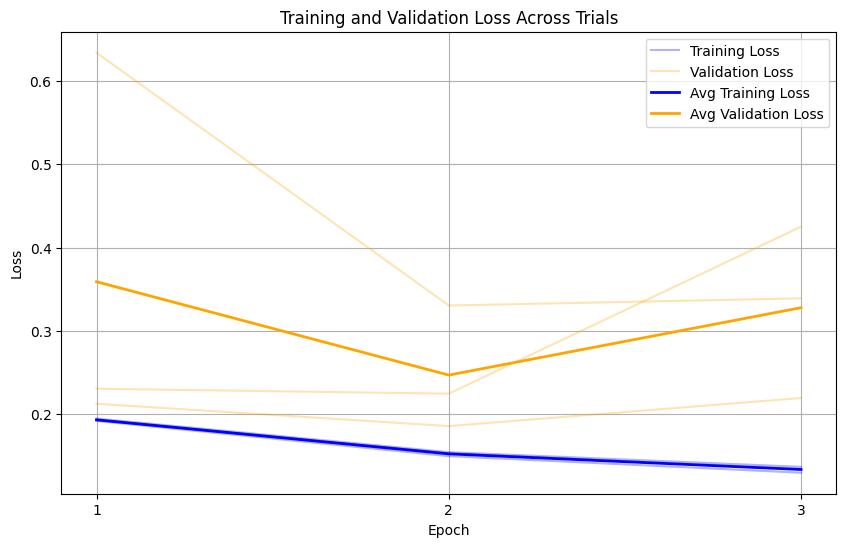

In [ ]:
# Train and plot
train_and_plot(train_loader, val_loader, create_googlenet, criterion, optimizer_fn,
               device, num_epochs=3, n_trials=3, patience=1, save_dir='/content/drive/MyDrive/ML Project 2 :)/Nat data augmentation/comparison1/clean_and_cracked/100%')

In [ ]:
# Example DataFrame
data = {
    "Trial 1": [0.2245, 0.1859],
    "Trial 2": [0.1945, 0.3306],
    "Trial 3": [0.2038, 0.2248],
}
df = pd.DataFrame(data, index=["Baseline", "100-100"])

# Calculate mean and std for each row
df["Mean"] = df.mean(axis=1)
df["Std"] = df.std(axis=1)

# Compute t-test p-values between each label and the baseline
baseline_mean = df.loc["Baseline", "Mean"]
baseline_std = df.loc["Baseline", "Std"]
baseline_n = df.shape[1] - 2  # Number of trials (subtract "Mean" and "Std" columns)

def compute_p_value(row):
    label_mean = row["Mean"]
    label_std = row["Std"]
    label_n = baseline_n  # Assuming equal number of trials
    t_stat, p_value = ttest_ind_from_stats(
        mean1=label_mean, std1=label_std, nobs1=label_n,
        mean2=baseline_mean, std2=baseline_std, nobs2=baseline_n,
        equal_var=False  # Welch's t-test for unequal variance
    )
    return p_value

# Add p-values column
df["p_value"] = df.apply(compute_p_value, axis=1)

# Drop "p_value" for baseline row (optional)
df.loc["Baseline", "p_value"] = None

# Highlight p-values < 0.05 in bold
def format_p_value(p):
    if pd.notna(p) and p < 0.05:
        return f"**{p:.4f}**"
    elif pd.notna(p):
        return f"{p:.4f}"
    else:
        return "NaN"

df["p_value"] = df["p_value"].apply(format_p_value)

print(df)

          Trial 1  Trial 2  Trial 3    Mean       Std p_value
Baseline   0.2245   0.1945   0.2038  0.2076  0.012539     NaN
100-100    0.1859   0.3306   0.2248  0.2471  0.061142  0.3797


Therefore keeping to the 50% clean and 50% cracked augmentation seems like a better option.